In [2]:
import collections
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

%matplotlib inline

In [5]:
class Relation(pd.DataFrame):

    def __init__(self, *args, **kwargs):
        name = kwargs.pop('name', None)
        super().__init__(*args, **kwargs)
        self.name = name
        
    @property
    def _constructor(self):
        return Relation
    
    @property
    def attributes(self):
        return self.columns.tolist()
    
    
class Relationship():
    
    def __init__(self, rel_from, rel_from_on, rel_to, rel_to_on):
        self.rel_from = rel_from
        self.rel_to = rel_to
        self.rel_from_on = rel_from_on
        self.rel_to_on = rel_to_on
        
    def __str__(self):
        return f'{self.rel_from}.{self.rel_from_on} <-> {self.rel_to}.{self.rel_to_on}'
        
        
class Metadata():
    
    def __init__(self, relationships):
        self.relationships = [
            Relationship(*(r[0].split('.') + r[1].split('.')))
            for r in relationships
        ]
  
    
class Database():
    
    def __init__(self, name, relations, relationships):
        self.name = name
        self.relations = relations
        self.metadata = Metadata(relationships)
        
    def get_relation_by_name(self, name):
        return next((rel for rel in self.relations if rel.name == name), None)
    
    def get_relationship(self, left, right):
        
        def matches(relationship):
            relations = set((relationship.rel_from, relationship.rel_to))
            return left in relations and right in relations
        
        return next((rel_ship for rel_ship in self.metadata.relationships if matches(rel_ship)), None)
        
    def join(self, left, right):
        
        rel_ship = self.get_relationship(left, right)
        
        left_rel = self.get_relation_by_name(rel_ship.rel_from)
        right_rel = self.get_relation_by_name(rel_ship.rel_to)
        
        return Relation(
            name=f'{rel_ship.rel_from}_{rel_ship.rel_to}',
            data=pd.merge(
                left=left_rel.rename(columns={c: f'{rel_ship.rel_from}__{c}' for c in left_rel.columns}),
                right=right_rel.rename(columns={c: f'{rel_ship.rel_to}__{c}' for c in right_rel.columns}),
                left_on=f'{rel_ship.rel_from}__{rel_ship.rel_from_on}',
                right_on=f'{rel_ship.rel_to}__{rel_ship.rel_to_on}'
            )
        )

In [6]:
players = Relation(
    name='players',
    data=[
        (1, 'male'),
        (2, 'female'),
        (3, 'male'),
        (4, 'male')
    ],
    columns=('id', 'gender')
)

characters = Relation(
    name = 'characters',
    data=[
        (1, 'male'),
        (1, 'male'),
        (1, 'male'),
        (1, 'male'),
        (1, 'male'),
        (1, 'male'),
        (1, 'male'),
        (1, 'female'),
        (1, 'female'),
        (2, 'female')
    ],
    columns=('player_id', 'gender')
)

db = Database(
    name='MMORPG',
    relations=[players, characters],
    relationships=[
        ('players.id', 'characters.player_id')
    ]
)

db.join('players', 'characters')

,players__id,players__gender,characters__player_id,characters__gender
0,1,male,1,male
1,1,male,1,male
2,1,male,1,male
3,1,male,1,male
4,1,male,1,male
5,1,male,1,male
6,1,male,1,male
7,1,male,1,female
8,1,male,1,female
9,2,female,2,female


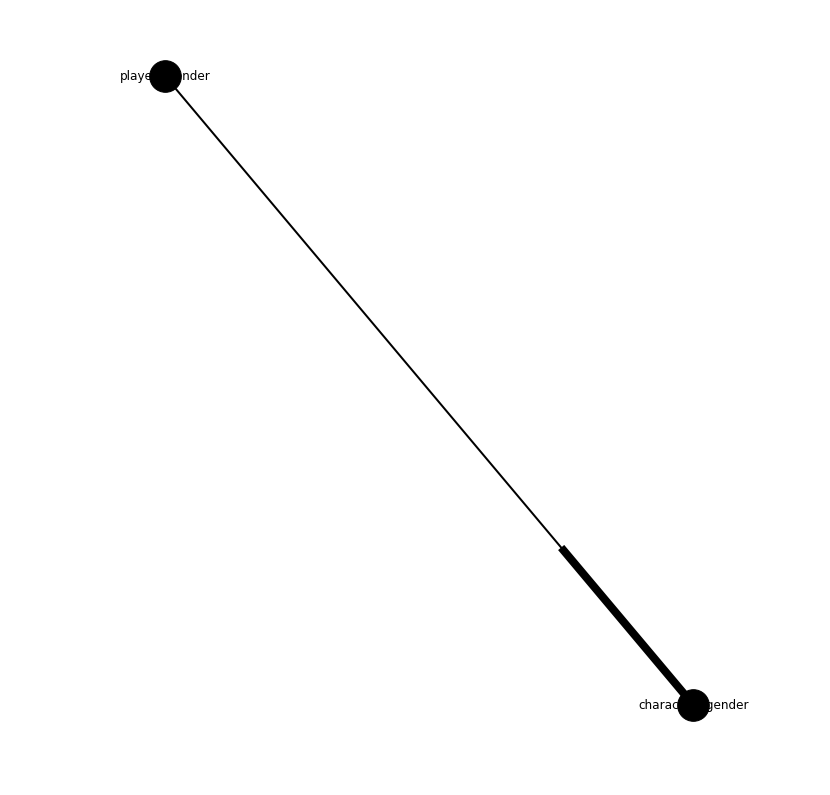

In [4]:
class DAG(nx.DiGraph):
    
    def __init__(self, dependencies):
        super().__init__()
        
        # Add the nodes to the DAG
        self.add_nodes_from(set(itertools.chain(*dependencies)))

        # Add the dependencies
        self.add_edges_from(dependencies)
        
    @property
    def is_acyclic(self):
        return next(nx.simple_cycles(dag), None) is None
    
    def draw(self, ax):
        nx.draw(
            dag,
            with_labels=True,
            ax=ax,
            **{
                'node_color': 'black',
                'node_size': 1000,
                'width': 2,
            }
        )
    
    
dag = DAG(
    dependencies=[
        ('players.gender', 'characters.gender'),
    ]
)

fig, ax = plt.subplots(figsize=(14, 14))

dag.draw(ax=ax)

In [8]:
class CPD(pd.DataFrame):
    
    def __init__(self, df, on, by, relative=True):
        
        # Make sure by is a list
        by = by if isinstance(by, list) else [by]
    
        counts = df.groupby([on] + by).size().to_frame('frequency').reset_index()
        cpd = pd.pivot_table(data=counts, index=by, columns=on, values='frequency').fillna(0)
        
        if relative:
            cpd = cpd.div(cpd.sum(axis='columns'), axis='rows')
        
        super().__init__(data=cdp)   
            
    @property
    def _constructor(self):
        return CPD
    
    
class BayesianNetwork():
    
    def __init__(self, db, dag):
        self.db
        self.dag = dag
     
    
cpd = CPD(db.join('players', 'characters'), on='characters__gender', by=None)
cpd

TypeError: 'NoneType' object is not callable

In [35]:
class PD(pd.DataFrame):
    
    def __init__(self, df, on, relative=True):
        
        # Make sure on is a list
        on = on if isinstance(on, list) else [on]
    
        freqs = df.groupby(on).size().to_frame('frequency').reset_index()
        
        if relative:
            freqs['frequency'] /= freqs['frequency'].sum()
        
        super().__init__(data=freqs)   
            
    @property
    def _constructor(self):
        return PD
    

db.join('players', 'characters')
PD(db.join('players', 'characters'), on=['players__gender', 'characters__gender'])

,players__gender,characters__gender,frequency
0,female,female,0.1
1,male,female,0.2
2,male,male,0.7


In [7]:
class Histogram(pd.DataFrame):
    
    def __init__(self, values, n_bins):
        n_bins = len(values) if n_bins == -1 else n_bins
        counts = pd.Series(collections.Counter(pd.cut(values, bins=n_bins)))
        super().__init__(data=counts.to_frame('count'))
            
    @property
    def _constructor(self):
        return Histogram
    
    

values = ['tim', 'tim', 'tom', 'zed', 'bill', 'chang', 'ching']
n = len(values)
n_bins = 3
bucket_width = n / n_bins 
collections.Counter(values)
buckets = 'a'

In [24]:
R = Relation(
    name='R',
    data=[
        ('a', 'c', 1),
        ('a', 'c', 2),
        ('b', 'c', 2),
        ('a', 'd', 3),
        ('b', 'd', 5)
    ],
    columns=('X', 'Y', 'A')
)

S = Relation(
    name = 'S',
    data=[
        (1, 'e', 'g'),
        (2, 'f', 'g'),
        (6, 'e', 'h'),
        (3, 'f', 'g')
    ],
    columns=('B', 'Z', 'W')
)

db = Database(
    name='tzoumas11',
    relations=[R, S],
    relationships=[
        ('R.A', 'S.B')
    ]
)

,R__X,R__Y,R__A,S__B,S__Z,S__W
0,a,c,1,1,e,g
1,a,c,2,2,f,g
2,b,c,2,2,f,g
3,a,d,3,3,f,g


In [31]:
PD(db.join('R', 'S'), on=['R__Y', 'S__Z'])

,R__Y,S__Z,frequency
0,c,e,0.25
1,c,f,0.50
2,d,f,0.25
